In [4]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/My Drive/SMART-CITIES/

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive/My Drive/SMART-CITIES


In [5]:
!pip install pysal

In [6]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import folium
import branca.colormap as cm
from folium.plugins import AntPath
from pysal.lib import weights
from pysal.explore import esda

In [7]:
# File paths
file1 = './raw/DB1.csv'
file2 = './raw/DB2.csv'
file3 = './raw/DB3.csv'
file4 = './raw/DB4.csv'

# Read the CSV files into DataFrames
df1 = pd.read_csv(file1)
df2 = pd.read_csv(file2)
df3 = pd.read_csv(file3)
df4 = pd.read_csv(file4)

# Define the new header
new_header = ['Timestamp', 'Temperature', 'Humidity', 'Air Quality', 'Latitude', 'Longitude']

# Set the header
df1.columns = new_header
df2.columns = new_header
df3.columns = new_header
df4.columns = new_header

# Adjust timestamp type
df1['Timestamp'] = pd.to_datetime(df1['Timestamp'], format='%d/%m/%Y%H:%M:%S')
df2['Timestamp'] = pd.to_datetime(df2['Timestamp'], format='%d/%m/%Y %H:%M:%S')
df3['Timestamp'] = pd.to_datetime(df3['Timestamp'], format='%d/%m/%Y %H:%M:%S')
df4['Timestamp'] = pd.to_datetime(df4['Timestamp'], format='%d/%m/%Y %H:%M:%S')

# Define the cutoff timestamp
begin_timestamp = pd.Timestamp('2024-06-20 15:24:00')
end_timestamp = pd.Timestamp('2024-06-20 15:55:00')

# Filter the DataFrame

filtered_df1 = df1[df1['Timestamp'] >= begin_timestamp]

filtered_df1 = filtered_df1[filtered_df1['Timestamp'] <= end_timestamp]

filtered_df2 = df2[df2['Timestamp'] >= begin_timestamp]

filtered_df2 = filtered_df2[filtered_df2['Timestamp'] <= end_timestamp]

filtered_df3 = df3[df3['Timestamp'] >= begin_timestamp]

filtered_df3 = filtered_df3[filtered_df3['Timestamp'] <= end_timestamp]

filtered_df4 = df4[df4['Timestamp'] >= begin_timestamp]

filtered_df4 = filtered_df4[filtered_df4['Timestamp'] <= end_timestamp]

# Concatenate DataFrames vertically
df_combined = pd.concat([filtered_df1, filtered_df2, filtered_df3, filtered_df4], ignore_index=True)

# Save the concatenated dataframe to a new CSV file
output_file = './filtered/unified-db.csv'

# Save the combined DataFrame to a new CSV file
df_combined.to_csv(output_file, index=False)


In [8]:
# Load the CSV file to inspect its contents
data = pd.read_csv(output_file)

# Display the first few rows of the dataframe to understand its structure
data.head()

,Timestamp,Temperature,Humidity,Air Quality,Latitude,Longitude
0,2024-06-20 15:24:02,28.69,50.97,28,45.473469,9.202674
1,2024-06-20 15:24:07,28.73,50.74,27,45.473470,9.202674
2,2024-06-20 15:24:12,28.78,49.94,27,45.473470,9.202674
3,2024-06-20 15:24:17,28.80,49.66,29,45.473470,9.202674
4,2024-06-20 15:24:22,28.77,49.70,27,45.473470,9.202673


In [9]:
# Describe the dataset
data.describe().T

,count,mean,std,min,25%,50%,75%,max
Temperature,1302.0,28.931974,0.716834,27.370000,28.420000,28.900000,29.370000,31.170000
Humidity,1302.0,48.555760,2.679079,43.030000,46.500000,48.240000,49.980000,59.470000
Air Quality,1302.0,39.691244,11.498216,24.000000,28.000000,37.000000,46.000000,74.000000
Latitude,1302.0,45.474262,0.001066,45.471935,45.473489,45.474102,45.474859,45.477260
Longitude,1302.0,9.200012,0.002210,9.195724,9.198159,9.199922,9.201978,9.204596


In [10]:
# Drop NaN rows
data = data.dropna()

In [11]:
# Filter out outliers
data = data[np.abs(data['Temperature']-data['Temperature'].mean()) <= (3*data['Temperature'].std())]

In [12]:
# Describe the dataset
data.describe().T

,count,mean,std,min,25%,50%,75%,max
Temperature,1301.0,28.930254,0.714416,27.370000,28.420000,28.900000,29.370000,30.940000
Humidity,1301.0,48.558640,2.678094,43.030000,46.500000,48.250000,49.980000,59.470000
Air Quality,1301.0,39.676403,11.490155,24.000000,28.000000,37.000000,46.000000,74.000000
Latitude,1301.0,45.474263,0.001065,45.471935,45.473489,45.474105,45.474860,45.477260
Longitude,1301.0,9.200010,0.002211,9.195724,9.198159,9.199916,9.201978,9.204596


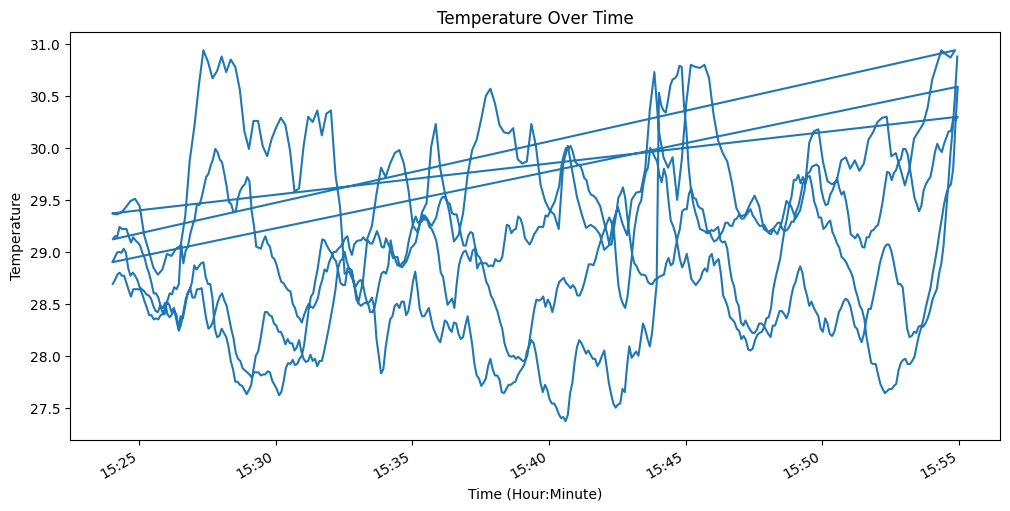

In [28]:
# Ensure the Timestamp column is in datetime format
data['Timestamp'] = pd.to_datetime(data['Timestamp'])

plt.figure(figsize=(12, 6))

# Plotting the data using the 'Timestamp' column for the x-axis
plt.plot(data['Timestamp'], data['Temperature'])

# Formatting the x-axis to show hour and minute
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

# Setting the labels and title
plt.xlabel('Time (Hour:Minute)')
plt.ylabel('Temperature')
plt.title('Temperature Over Time')

# Rotating the x-axis labels for better readability
plt.gcf().autofmt_xdate()

# Display the plot
plt.show()


In [14]:
# Center of the map (average of latitude and longitude)
map_center = [data['Latitude'].mean(), data['Longitude'].mean()]

# Create a map
mymap = folium.Map(location=map_center, zoom_start=15)

# Add points to the map
for idx, row in data.iterrows():
    folium.Marker([row['Latitude'], row['Longitude']],
                  popup=f"Temp: {row['Temperature']}, Humidity: {row['Humidity']}, Air Quality: {row['Air Quality']}").add_to(mymap)

mymap.save("./maps/map-unified.html")


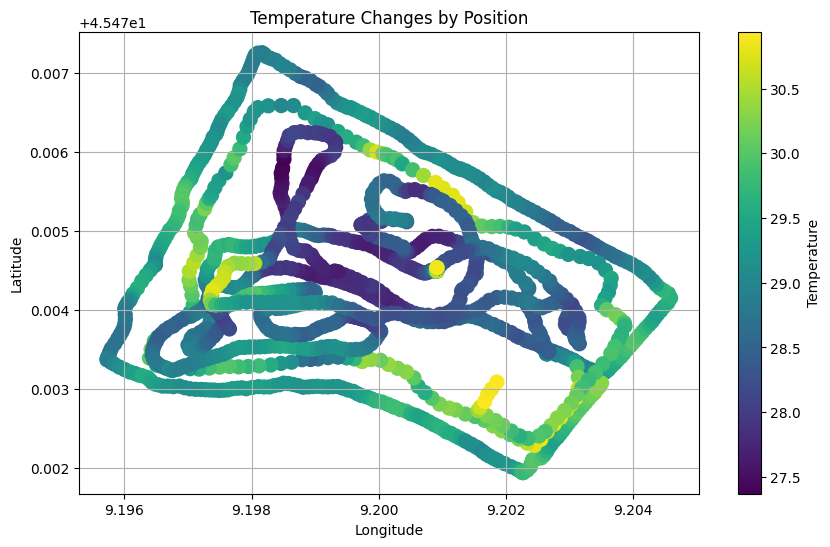

In [15]:
df = data.copy()
# Plot temperature vs coordinates
plt.figure(figsize=(10, 6))
sc = plt.scatter(df['Longitude'], df['Latitude'], c=df['Temperature'], cmap='viridis', s=100)
plt.colorbar(sc, label='Temperature')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Temperature Changes by Position')
plt.grid(True)
plt.show()

In [16]:
# Create a color map
colormap = cm.linear.YlOrRd_09.scale(df['Temperature'].min(), df['Temperature'].max())

# Create a map centered around the average latitude and longitude
map_center = [df['Latitude'].mean(), df['Longitude'].mean()]
m = folium.Map(location=map_center, zoom_start=15)

# Add temperature data as circle markers with color according to temperature
for idx, row in df.iterrows():
    folium.CircleMarker(
        location=[row['Latitude'], row['Longitude']],
        radius=8,
        popup=f'Temperature: {row["Temperature"]} °C',
        color=colormap(row['Temperature']),
        fill=True,
        fill_color=colormap(row['Temperature']),
        fill_opacity=0.7
    ).add_to(m)

# Add colormap legend
colormap.caption = 'Temperature'
colormap.add_to(m)

# Save the map to an HTML file
m.save('./temperature-maps/temp-map-unified.html')

In [17]:
# Create a color map
colormap = cm.linear.YlOrRd_09.scale(df['Temperature'].min(), df['Temperature'].max())

# Create a map centered around the average latitude and longitude
map_center = [df['Latitude'].mean(), df['Longitude'].mean()]
m = folium.Map(location=map_center, zoom_start=15, tiles='https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}', attr="<a href=https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}>Felipe</a>")

# Add temperature data as circle markers with color according to temperature
for idx, row in df.iterrows():
    folium.CircleMarker(
        location=[row['Latitude'], row['Longitude']],
        radius=8,
        popup=f'Temperature: {row["Temperature"]} °C',
        color=colormap(row['Temperature']),
        fill=True,
        fill_color=colormap(row['Temperature']),
        fill_opacity=0.7
    ).add_to(m)

# Add colormap legend
colormap.caption = 'Temperature'
colormap.add_to(m)

# Save the map to an HTML file
m.save('./temperature-maps/temp-map-unified-sat.html')

In [19]:
# Create a list of coordinates
coordinates = list(zip(df['Latitude'], df['Longitude']))

# Create a distance-based weights matrix
distance_band = 100  # Adjust the distance threshold as needed
w = weights.DistanceBand.from_array(coordinates, threshold=distance_band)

# Calculate Moran's I
moran = esda.Moran(df['Temperature'], w)

# Interpretation
# Moran’s I: Values range from -1 (perfect dispersion) to +1 (perfect correlation). A value close to 0 indicates random spatial patterning.
# P-value: Determines the significance of the Moran’s I value. A low p-value (typically < 0.05) indicates significant spatial autocorrelation.
print(f"Moran's I: {moran.I}")
print(f"P-value: {moran.p_norm}")

Moran's I: -0.0007692792438531896
P-value: 0.9673018334625328


/usr/local/lib/python3.10/dist-packages/libpysal/weights/distance.py:153: UserWarning: The weights matrix is not fully connected: 
 There are 17 disconnected components.
  W.__init__(self, neighbors, id_order=ids, **kwargs)


REGRESSION RESULTS
------------------

SUMMARY OF OUTPUT: MAXIMUM LIKELIHOOD SPATIAL LAG (METHOD = FULL)
-----------------------------------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  : Temperature                Number of Observations:        1301
Mean dependent var  :     28.9303                Number of Variables   :           4
S.D. dependent var  :      0.7144                Degrees of Freedom    :        1297
Pseudo R-squared    :      0.8272
Spatial Pseudo R-squared:  0.0669
Log likelihood      :   -583.4636
Sigma-square ML     :      0.0984                Akaike info criterion :    1174.927
S.E of regression   :      0.3137                Schwarz criterion     :    1195.611

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
---------------------------------------------------------------

Text(0.5, 1.0, 'Spatial Regression Residuals')

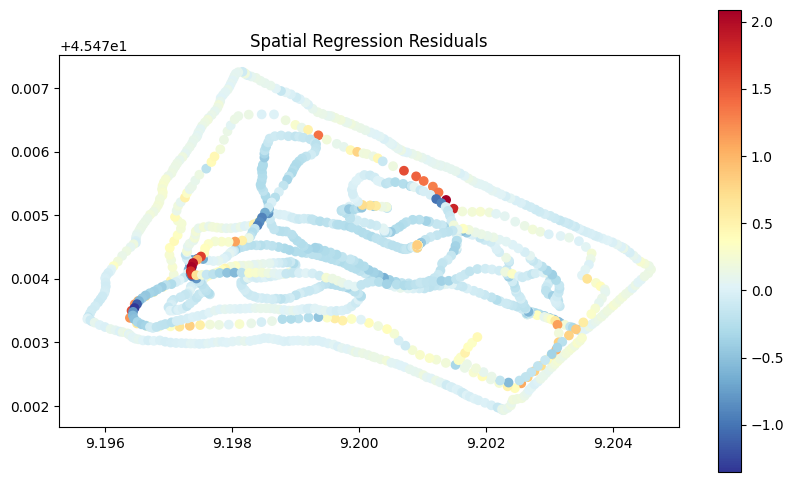

In [27]:
import numpy as np
import pandas as pd
import geopandas as gpd
import libpysal as lp
from spreg import ML_Lag
from spreg import diagnostics as diag

# Create a GeoDataFrame for visualization (optional)
geometry = gpd.points_from_xy(df['Longitude'], df['Latitude'])
gdf = gpd.GeoDataFrame(df, geometry=geometry)

# Create spatial weights matrix (based on k-nearest neighbors)
w = lp.weights.KNN.from_dataframe(gdf, k=2)

# Spatial lag model
y = df['Temperature'].values
x = np.ones_like(y)  # constant term
x = np.column_stack((x, df['Latitude'], df['Longitude']))  # include Latitude and Longitude as predictors

model = ML_Lag(y, x, w, name_y='Temperature', name_x=['constant', 'Latitude', 'Longitude'])

# Fit the model
results = model

# Print regression results
print(results.summary)

# Spatial diagnostics (Moran's I of residuals)
resid = results.u  # residuals
moran_res = esda.moran.Moran(resid, w)
print("\nMoran's I of residuals:", moran_res.I)
print("Moran's I p-value:", moran_res.p_sim)

# Visualization (optional)
gdf['residuals'] = resid
ax = gdf.plot(column='residuals', cmap='RdYlBu_r', legend=True, figsize=(10, 6))
ax.set_title('Spatial Regression Residuals')